<img src='../images/copernicus_eumetsat_logo.jpg' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

#  CAMS regional ozone forecasts
In this notebook we download a dataset of the ozone forecasts for an area over Europe at ground level, with a lead time of four days. We will make some simple calculations of the daily mean and maximum concentration of ozone, then we will choose a location, for example a city, and will create a time series for the ozone concentration to see whether there is a pattern such as a trend or cycle.

In [1]:
import numpy as np
import pandas as pd
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.colors as mcol
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import cdsapi
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("Pandas version: %s"%pd.__version__)
print("Xarray version: %s"%xr.__version__)

Python version: 3.11.5
Pandas version: 2.1.1
Xarray version: 2023.12.0


In [13]:
start_date = '2024-09-01'
end_date = '2024-09-01'
time = '00:00'
lead_time_start = 0
lead_time_stop = 96
step_hours = 1
leadtime_hours = list(range(lead_time_start, lead_time_stop + lead_time_start, step_hours))
variables = ['ozone']
models = ['ensemble']
levels = [0]
bb_north = 64.59
bb_south = 52.75
bb_west = 1.74
bb_east = 23.18
area = [bb_north, bb_west, bb_south, bb_east]  

In [27]:
DATADIR = 'data'
WDIR = f'cams_regioal_ozone_{start_date}_{end_date}'
target = f'{DATADIR}/{WDIR}.nc'

In [23]:
cams_dataset = 'cams-europe-air-quality-forecasts'

In [24]:
request = {
        'variable': variables,
		'date': f'{start_date}/{end_date}',
        'time': f'{time}',
        'leadtime_hour': leadtime_hours,
        'type': 'forecast',
        'model': models,
        'level': levels,
        'area': area,
        'format': 'netcdf'
    }

In [25]:
c = cdsapi.Client()
c.retrieve(cams_dataset, request, target)

2024-09-01 14:41:41,749 INFO Welcome to the CDS
2024-09-01 14:41:41,750 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2024-09-01 14:41:41,788 INFO Request is queued
2024-09-01 14:41:42,820 INFO Request is running
2024-09-01 14:42:02,743 INFO Request is completed
2024-09-01 14:42:02,745 INFO Downloading https://download-0000-ads-clone.copernicus-climate.eu/cache-compute-0000/cache/data4/adaptor.cams_regional_fc.retrieve-1725194516.8595476-3445-9-05be6e8a-2d58-4deb-9b99-26c7983abdb4.nc to data/cams_regioal_ozone_2024-09-01_2024-09-01.zip (9.4M)
2024-09-01 14:42:04,904 INFO Download rate 4.3M/s   


Result(content_length=9827568,content_type=application/x-netcdf,location=https://download-0000-ads-clone.copernicus-climate.eu/cache-compute-0000/cache/data4/adaptor.cams_regional_fc.retrieve-1725194516.8595476-3445-9-05be6e8a-2d58-4deb-9b99-26c7983abdb4.nc)

In [29]:
ozone_ds = xr.open_dataset(f'{DATADIR}/{WDIR}.nc') 
ozone_ds

<xarray.Dataset>
Dimensions:    (longitude: 215, latitude: 119, level: 1, time: 96)
Coordinates:
  * longitude  (longitude) float32 1.75 1.85 1.95 2.05 ... 22.95 23.05 23.15
  * latitude   (latitude) float32 64.55 64.45 64.35 64.25 ... 52.95 52.85 52.75
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 3 days 23:00:00
Data variables:
    o3_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        O3 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240901+[0H_95H]
    summary:      ENSEMBLE model hourly FORECAST of O3 concentration at the S...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [91]:
delta_forecast = 3600000000000 # delta between one lead time and the next one
num_forecasts = len(leadtime_hours) 
start_day = pd.to_datetime(start_date)
forecast_index = start_day + pd.to_timedelta(np.arange(num_forecasts), 'H')

In [37]:
ozone_dt_ds = ozone_ds.assign_coords(time=forecast_index)
ozone_dt_ds

<xarray.Dataset>
Dimensions:    (longitude: 215, latitude: 119, level: 1, time: 96)
Coordinates:
  * longitude  (longitude) float32 1.75 1.85 1.95 2.05 ... 22.95 23.05 23.15
  * latitude   (latitude) float32 64.55 64.45 64.35 64.25 ... 52.95 52.85 52.75
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2024-09-01 ... 2024-09-04T23:00:00
Data variables:
    o3_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        O3 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240901+[0H_95H]
    summary:      ENSEMBLE model hourly FORECAST of O3 concentration at the S...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [53]:
latitude = ozone_dt_ds.latitude
longitude = ozone_dt_ds.longitude

In [50]:
o3_concentration_da = ozone_dt_ds['o3_conc']
o3_concentration_da

<xarray.DataArray 'o3_conc' (time: 96, level: 1, latitude: 119, longitude: 215)>
[2456160 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 1.75 1.85 1.95 2.05 ... 22.95 23.05 23.15
  * latitude   (latitude) float32 64.55 64.45 64.35 64.25 ... 52.95 52.85 52.75
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2024-09-01 ... 2024-09-04T23:00:00
Attributes:
    species:        Ozone
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_ozone_in_air

## Daily max and mean concentrations

In [99]:
o3_concentration_daily_max_da = o3_concentration_da.resample(time='D').max()
o3_concentration_daily_mean_da = o3_concentration_da.resample(time='D').mean()

In [103]:
def plot_forecasts(xarray_da, num_forecasts, plot_title):
    '''
    Creates a plot of a data array
    '''
    fig, axs = plt.subplots(nrows=num_forecasts,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(30, 25))
    
    day_forecasts = xarray_da.time.values
    for i in range(num_forecasts):
        timestamp = day_forecasts[i]
        day = str(timestamp)[:10]
        data = xarray_da.sel(time=day, level=0.0)
        cs = axs[i].pcolormesh(xarray_da.longitude, 
                               xarray_da.latitude, 
                               data,  
                               cmap='RdYlBu_r', #'YlOrRd' 
                               transform=ccrs.PlateCarree())
    
        cbar = plt.colorbar(cs, fraction=0.046, pad=0.05, orientation='vertical', shrink=0.75)
        cbar.set_label(' $\mu g \cdot m^{-3}$')
        axs[i].set_extent([bb_west, bb_east, bb_south, bb_north], crs=ccrs.PlateCarree()) 
        axs[i].set_title(plot_title + day)
        axs[i].coastlines(color='black', alpha=0.7) 
        axs[i].add_feature(cfeature.LAKES, alpha=0.7, edgecolor='black', facecolor='none')
        axs[i].add_feature(cfeature.BORDERS, alpha=0.7)
        axs[i].gridlines(draw_labels=False, linestyle='--')
        axs[i].margins(0.5)

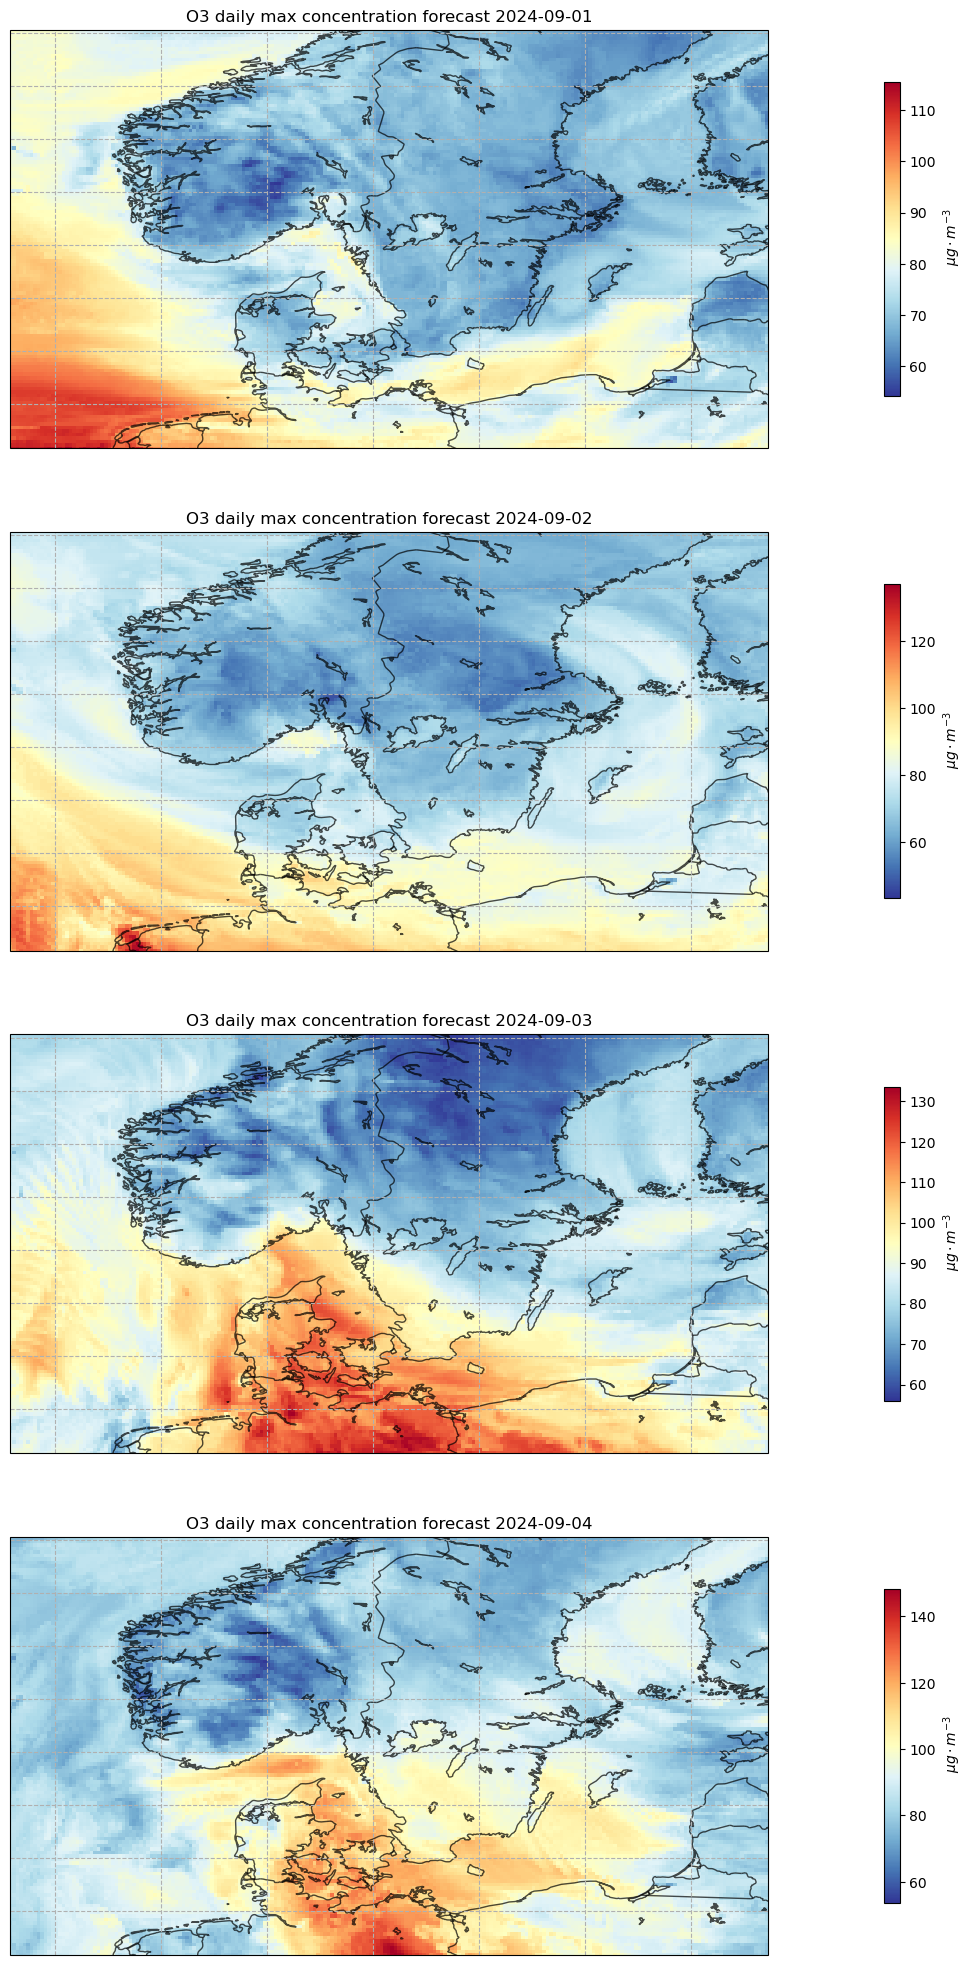

In [104]:
plot_forecasts(o3_concentration_daily_max_da, 4, 'O3 daily max concentration forecast ')

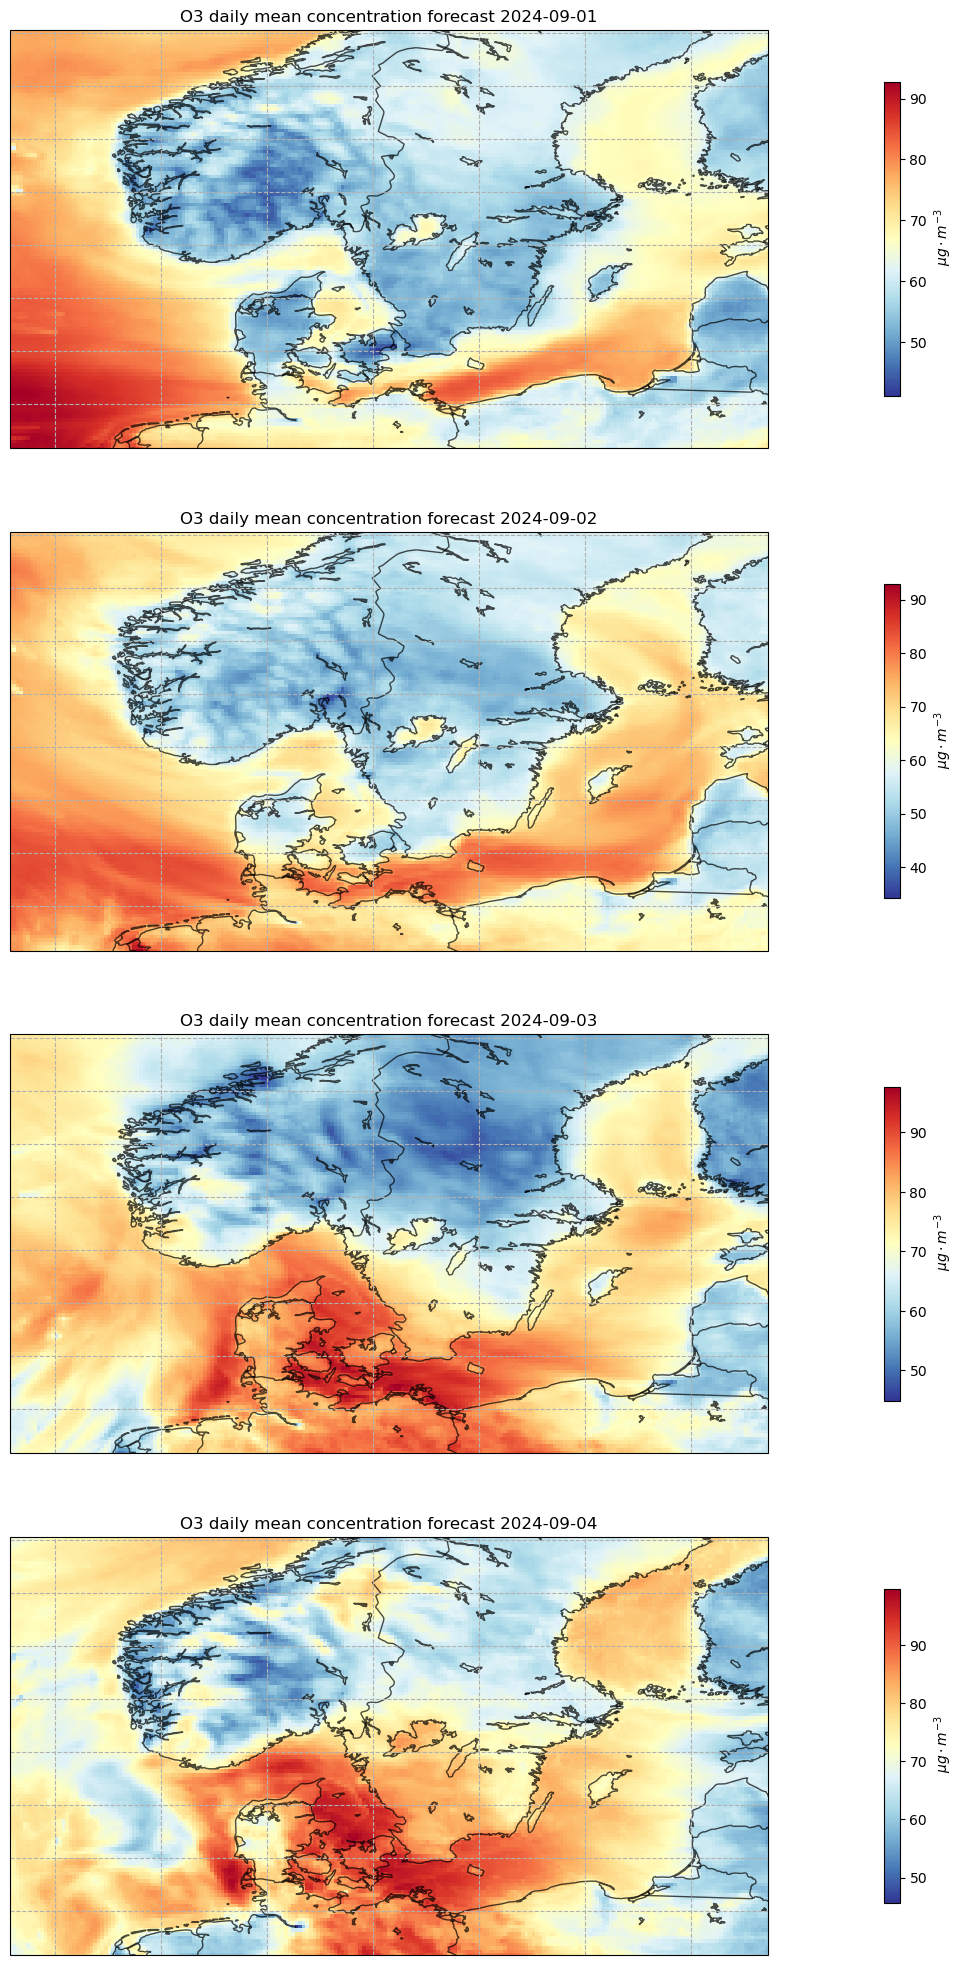

In [98]:
plot_forecasts(o3_concentration_daily_mean_da, 4, 'O3 daily mean concentration forecast ')

## Time series of $O_3$ concentration forecast

In [105]:
oslo_lat = 59.9124 
oslo_lon = 10.733716997341721

In [107]:
oslo_o3_concentration_da = o3_concentration_da.sel(latitude = oslo_lat, longitude = oslo_lon, method='nearest', level=0.0)
oslo_o3_concentration_da

<xarray.DataArray 'o3_conc' (time: 96)>
[96 values with dtype=float32]
Coordinates:
    longitude  float32 10.75
    latitude   float32 59.95
    level      float32 0.0
  * time       (time) datetime64[ns] 2024-09-01 ... 2024-09-04T23:00:00
Attributes:
    species:        Ozone
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_ozone_in_air

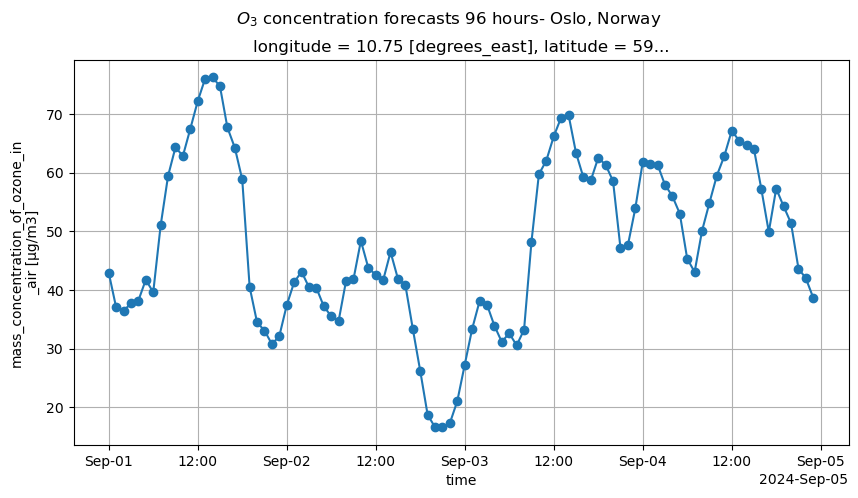

In [109]:
fig = plt.figure(figsize=(10, 5))
oslo_o3_concentration_da.plot(marker='o')
plt.suptitle("$O_3$ concentration forecasts 96 hours- Oslo, Norway")
plt.grid(True)